In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import time
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from calculate_expected_value import calculate_expected_value
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
import networkx as nx

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
n_qubits = 4
n_samples = 55
beta = 1.0

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハミルトニアンは、開放境界条件の 1 次元ハイゼンベルグ模型 : 

\begin{aligned}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{aligned}

相互作用強度 $J_i$ は $[-1, 1]$ の一様分布からランダムに選ぶ。

これを networkx のグラフとして表す。

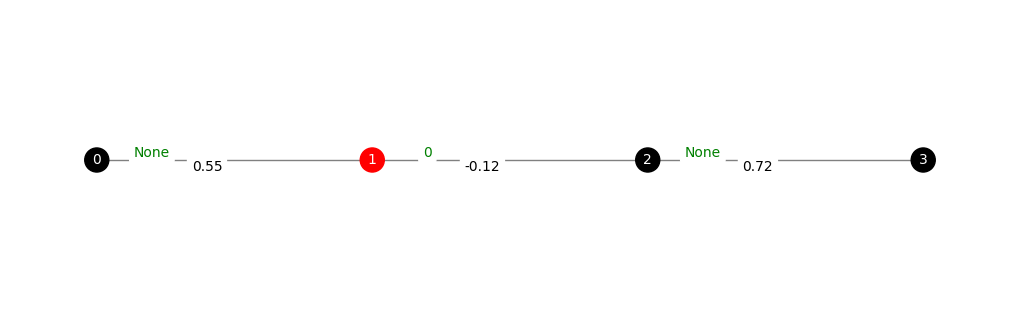

In [6]:
rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

## データセットの作成

教師あり学習用のデータセット、すなわち input と output が組になったデータセットを作る。

input: Hamiltonian $H$

output: $y(H)=\operatorname{Tr}[f(H)\rho]$

今回は
- $f(H)=e^{-\beta H}$
- $\rho$ は純粋状態 $\rho=\ket{\psi}\bra{\psi}, \ket{\psi}=\ket{0011\cdots1100}$ (真ん中半分が 1, それ以外は 0)

とする。すなわち

output: $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$

となる。以下ではまず、$\ket{\psi}=\ket{0011\cdots1100}$ を作成する。

次に、$y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$ を虚時間 TEBD で計算してデータセットを作る。12 量子ビット以下は厳密対角化と比較して、虚時間 TEBD の結果が合っているか確かめる。

In [12]:
data = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    Js = rng.uniform(-1, 1, size=n_qubits - 1)

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    data.append(
        {
            "sample": i,
            "Js": Js,
            "expected_value": expected_value_tebd,
            "expected_value_diag": expected_value_diag,
            "diff": diff,
        }
    )

df = pd.DataFrame(data)
print(
    "Note: The expected value is calculated by TEBD. \nFor small number of qubits, to check the accuracy, the expected value is also calculated by diagonalizing the Hamiltonian."
)
display(df)
df["expected_value"].describe()

# json に保存 (orient="records" で行ごとに保存)
df.to_json(f"results/get_dataset/{n_qubits}Q_dataset.json", orient="records", indent=4)

Sample 0/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 1/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 2/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 3/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 4/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 5/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 6/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 7/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 8/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 9/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.00[s]

Sample 10/55
Elapsed time for TEBD: 0.41[s]
Elapsed time for diagonalization: 0.01[s]

Sample 11/55
Elapsed time for TEBD: 0.42[s]
Elapsed t

,sample,Js,expected_value,expected_value_diag,diff
0,0,"[0.5479120971119267, -0.12224312049589536, 0.7...",13.899247,13.899220,2.726161e-05
1,1,"[0.3947360581187278, -0.8116453042247009, 0.95...",28.586491,28.585213,1.278298e-03
2,2,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653078,2.653082,3.712606e-06
3,3,"[-0.09922812420886573, -0.25840395153483753, 0...",7.222994,7.222891,1.023508e-04
4,4,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865096,0.865078,1.800547e-05
5,5,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138947,1.138950,2.786283e-06
6,6,"[0.6552623439851641, 0.2633287982441297, 0.516...",9.060702,9.060659,4.298705e-05
7,7,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.366950,4.367027,7.663199e-05
8,8,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566096,4.566077,1.851977e-05
9,9,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720388,3.720380,8.204786e-06


### (付録) 量子ビットを増やした時の TEBD と厳密対角化の比較

In [13]:
n_qubits_list = [4, 8, 12, 20, 40, 60, 80, 100]
expected_values_tebd = []
expected_values_diag = []
diffs = []
rng = np.random.default_rng(42)
n_qubits_diag_upper_bound = 12

for n_qubits in n_qubits_list:
    print(f"processing for {n_qubits} qubits...")
    # [-1, 1] の一様分布から結合定数 Js の組を 1 組生成する
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    expected_values_tebd.append(expected_value_tebd)
    expected_values_diag.append(expected_value_diag)
    diffs.append(diff)

df = pd.DataFrame(
    {
        "n_qubits": n_qubits_list,
        "expected_value_tebd": expected_values_tebd,
        "expected_value_diag": expected_values_diag,
        "diff": diffs,
    }
)
display(df)

processing for 4 qubits...
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

processing for 8 qubits...
Elapsed time for TEBD: 0.98[s]
Elapsed time for diagonalization: 0.03[s]

processing for 12 qubits...
Elapsed time for TEBD: 1.50[s]
Elapsed time for diagonalization: 25.81[s]

processing for 20 qubits...
Elapsed time for TEBD: 2.63[s]

processing for 40 qubits...
Elapsed time for TEBD: 5.02[s]

processing for 60 qubits...
Elapsed time for TEBD: 7.28[s]

processing for 80 qubits...
Elapsed time for TEBD: 9.69[s]

processing for 100 qubits...
Elapsed time for TEBD: 11.99[s]



,n_qubits,expected_value_tebd,expected_value_diag,diff
0,4,13.899247,13.899220,0.000027
1,8,1.025275,1.025050,0.000226
2,12,5.438367,5.438322,0.000045
3,20,0.792024,NaN,NaN
4,40,3.795994,NaN,NaN
5,60,21.428468,NaN,NaN
6,80,29.888452,NaN,NaN
7,100,15008.987215,NaN,NaN
